# Pretrained Models

Keras comes with many model already pretrained on imagenet.

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet
* DenseNet
* NASNet
* MobileNetV2

We can easily take these models and retrain them to achieve what we want, if you don't have access to powerfull GPUs this may be a more feasiable approach then starting from scratch.

In [1]:
import keras
keras.__version__

C:\Users\Brian Tsang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.0'

In [1]:
import keras
keras.__version__

/home/dom/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.6'

We can check which devices are avaliable using with keras. 

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

We'll download a pretrain model without the top, meaning without the fully connected layers. We'll then use the bottom half of the model as a feature extractor and retrain our own fully connected layer for classication. This is a very computational cheap (and quick) way to build a image recognition algorithm, however you will probaly get better results if you do retrain the feature extractor part.

In [4]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1096s 19us/step


In [5]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

When working with large datasets like lots of images we, don't want to load them all into memory at once. We can use generators to load the images in batches. Keras has some utilites to help with this called`ImageDataGenerator`, it can load images in batchs and reshape them for us, aswell as be used to apply image augmentation. To use the ImageDataGenerator or  data directory has to be in a particular structure, so that the images for each example are in there own folder. 

```
/home/dom/datasets/cat-vs-dog
├── cat
└── dog
```


For more details on the image generator see [here](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model).  The dataset was downloaded from [here](https://www.kaggle.com/c/dogs-vs-cats/data).


In [5]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm # library for progress bars

In [6]:
path = '/home/dom/datasets/cat-vs-dog'

The function below uses a image generator to load the images in batches and will use the base of the convlutional network to extract features from them.

In [71]:
def extract_features(directory, sample_count, batch_size= 100):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))

    datagen = ImageDataGenerator(rescale=1./255)
    
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    
    with tqdm(total=sample_count) as pbar:
        for inputs_batch, labels_batch in generator:
            #We use the conv_base to extract the images features
            features_batch = conv_base.predict(inputs_batch)
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels[i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1
            pbar.update(batch_size)
            if i * batch_size >= sample_count:
                # Note that since generators yield data indefinitely in a loop,
                # we must `break` after every image has been seen once.
                break
        return features, labels


In [72]:
n_samples = 10000 # use a lower number if you don't havea GPU

In [73]:
features, labels = extract_features(path,n_samples) # extract features for 1000 images

Found 25000 images belonging to 2 classes.


100%|██████████| 10000/10000 [00:55<00:00, 179.63it/s]


In [74]:
features.shape

(10000, 4, 4, 512)

In [75]:
features = np.reshape(features, (n_samples, 4 * 4 * 512))#flatten lay output

Now that we have extracted the features we just need to retrain a classifier.

In [77]:
from keras import models
from keras import layers
from keras import optimizers

In [80]:
#Here we'll retrain a classifier.
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])



In [81]:
history = model.fit(features, labels,
                    epochs=50,
                    batch_size=1024,
                    validation_split=0.2 )

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 1s 107us/step - loss: 0.6898 - acc: 0.5754 - val_loss: 0.5815 - val_acc: 0.7790
Epoch 2/50
8000/8000 [==============================] - 1s 66us/step - loss: 0.5862 - acc: 0.6913 - val_loss: 0.5138 - val_acc: 0.8130
Epoch 3/50
8000/8000 [==============================] - 1s 70us/step - loss: 0.5234 - acc: 0.7549 - val_loss: 0.4630 - val_acc: 0.8245
Epoch 4/50
8000/8000 [==============================] - 0s 62us/step - loss: 0.4765 - acc: 0.7890 - val_loss: 0.4247 - val_acc: 0.8335
Epoch 5/50
8000/8000 [==============================] - 1s 65us/step - loss: 0.4386 - acc: 0.8089 - val_loss: 0.3961 - val_acc: 0.8440
Epoch 6/50
8000/8000 [==============================] - 1s 67us/step - loss: 0.4134 - acc: 0.8188 - val_loss: 0.3770 - val_acc: 0.8420
Epoch 7/50
8000/8000 [==============================] - 1s 67us/step - loss: 0.3915 - acc: 0.8305 - val_loss: 0.3596 - val_acc: 0.8525
Epoch 

In [82]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [83]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [84]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

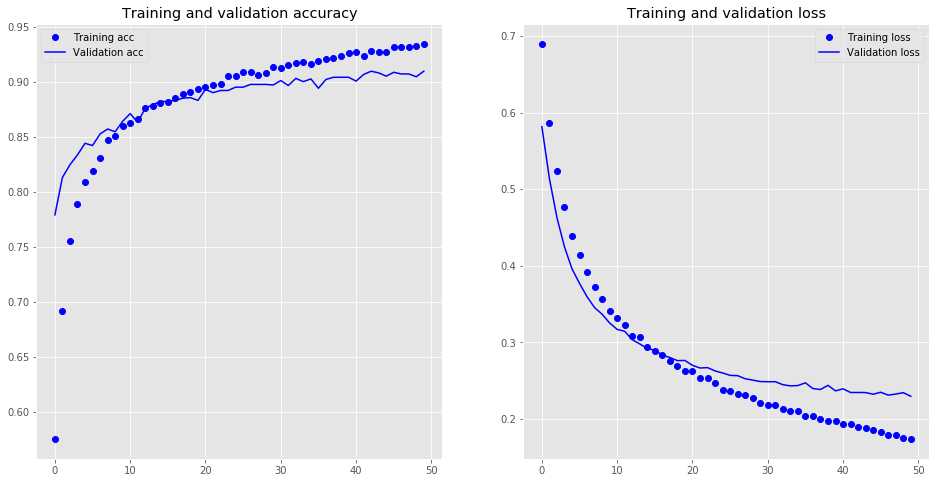

In [85]:
fig, axes = plt.subplots(1,2,figsize=(16,8))

axes[0].plot(acc, 'bo', label='Training acc')
axes[0].plot(val_acc, 'b', label='Validation acc')
axes[0].set_title('Training and validation accuracy')
axes[0].legend()

axes[1].plot(loss, 'bo', label='Training loss')
axes[1].plot(val_loss, 'b', label='Validation loss')
axes[1].set_title('Training and validation loss')
axes[1].legend()
